# DiscreteDP Example: Automobile Replacement

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

We study the finite-state version of the automobile replacement problem as considered in
Rust (1996, Section 4.2.2).

* J. Rust, "Numerical Dynamic Programming in Economics",
  <i>Handbook of Computational Economics</i>, Volume 1, 619-729, 1996.

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import numpy as np
import itertools
import scipy.optimize
import matplotlib.pyplot as plt
import pandas as pd
from quantecon.markov import DiscreteDP

## Setup

In [3]:
lambd = 0.5  # Exponential distribution parameter
c = 200  # (Constant) marginal cost of maintainance
net_price = 10**5  # Replacement cost

In [4]:
n = 100  # Number of states; s = 0, ..., n-1: level of utilization of the asset
m = 2  # Number of actions; 0: keep, 1: replace

In [5]:
# Reward array
R = np.empty((n, m))
R[:, 0] = -c * np.arange(n)  # Costs for maintainance
R[:, 1] = -net_price - c * 0  # Costs for replacement

In [6]:
# Transition probability array
# For each state s, s' distributes over
# s, s+1, ..., min{s+supp_size-1, n-1} if a = 0
# 0, 1, ..., supp_size-1 if a = 1
# according to the (discretized and truncated) exponential distribution
# with parameter lambd
supp_size = 12
probs = np.empty(supp_size)
probs[0] = 1 - np.exp(-lambd * 0.5)
for j in range(1, supp_size-1):
    probs[j] = np.exp(-lambd * (j - 0.5)) - np.exp(-lambd * (j + 0.5))
probs[supp_size-1] = 1 - np.sum(probs[:-1])

Q = np.zeros((n, m, n))

# a = 0
for i in range(n-supp_size):
    Q[i, 0, i:i+supp_size] = probs
for k in range(supp_size):
    Q[n-supp_size+k, 0, n-supp_size+k:] = probs[:supp_size-k]/probs[:supp_size-k].sum()

# a = 1
for i in range(n):
    Q[i, 1, :supp_size] = probs

In [7]:
# Discount factor
beta = 0.95

## Continuous-state benchmark

Let us compute the value function of the continuous-state version
as described in equations (2.22) and (2.23) in Section 2.3.

In [8]:
def f(x, s):
    return (c/(1-beta)) * \
        ((x-s) - (beta/(lambd*(1-beta))) * (1 - np.exp(-lambd*(1-beta)*(x-s))))

The optimal stopping boundary $\gamma$ for the contiuous-state version, given by (2.23):

In [9]:
gamma = scipy.optimize.brentq(lambda x: f(x, 0) - net_price, 0, 100)
print(gamma)

52.86545636058919


The value function for the continuous-state version, given by (2.24):

In [10]:
def value_func_cont_time(s):
    return -c*gamma/(1-beta) + (s < gamma) * f(gamma, s)

In [11]:
v_cont = value_func_cont_time(np.arange(n))

## Solving the problem with `DiscreteDP`

Construct a `DiscreteDP` instance for the disrete-state version:

In [12]:
ddp = DiscreteDP(R, Q, beta)

Let us solve the decision problem by

(0) value iteration,  
(1) value iteration with span-based termination
(equivalent to modified policy iteration with step $k = 0$),  
(2) policy iteration,  
(3) modified policy iteration.

Following Rust (1996), we set:

* $\varepsilon = 1164$ (for value iteration and modified policy iteration),
* $v^0 \equiv 0$,
* the number of iteration for iterative policy evaluation $k = 20$.

In [13]:
v_init = np.zeros(ddp.num_states)
epsilon = 1164
methods = ['vi', 'mpi', 'pi', 'mpi']
labels = ['Value iteration', 'Value iteration with span-based termination',
          'Policy iteration', 'Modified policy iteration']
results = {}

for i in range(4):
    k = 20 if labels[i] == 'Modified policy iteration' else 0
    results[labels[i]] = \
        ddp.solve(method=methods[i], v_init=v_init, epsilon=epsilon, k=k)

In [14]:
columns = [
    'Iterations', 'Time (second)', r'$\lVert v - v_{\mathrm{pi}} \rVert$',
    r'$\overline{b} - \underline{b}$', r'$\lVert v - T(v)\rVert$'
]
df = pd.DataFrame(index=labels, columns=columns)

The numbers of iterations:

In [15]:
for label in labels:
    print(results[label].num_iter, '\t' + '(' + label + ')')
    df[columns[0]].loc[label] = results[label].num_iter

114 	(Value iteration)
65 	(Value iteration with span-based termination)
5 	(Policy iteration)
6 	(Modified policy iteration)


Policy iteration gives the optimal policy:

In [16]:
print(results['Policy iteration'].sigma)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Takes action 1 ("replace") if and only if $s \geq \bar{\gamma}$, where $\bar{\gamma}$ is equal to:

In [17]:
(1-results['Policy iteration'].sigma).sum()

53

Check that the other methods gave the correct answer:

In [18]:
for result in results.values():
    if result != results['Policy iteration']:
        print(np.array_equal(result.sigma, results['Policy iteration'].sigma))

True
True
True


The deviations of the returned value function from the continuous-state benchmark:

In [19]:
diffs_cont = {}
for label in labels:
    diffs_cont[label] = np.abs(results[label].v - v_cont).max()
    print(diffs_cont[label], '\t' + '(' + label + ')')

1733.77910196 	(Value iteration)
1085.80571693 	(Value iteration with span-based termination)
1162.88060863 	(Policy iteration)
1144.47728382 	(Modified policy iteration)


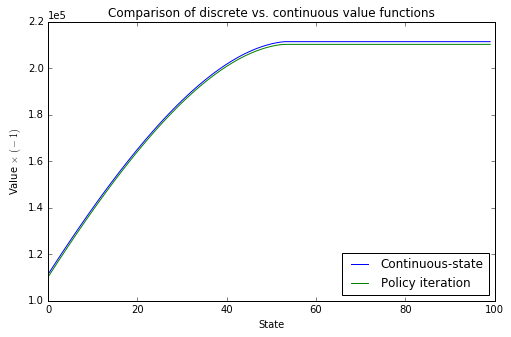

In [20]:
label = 'Policy iteration'
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(-v_cont, label='Continuous-state')
ax.plot(-results[label].v, label=label)
ax.set_title('Comparison of discrete vs. continuous value functions')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xlabel('State')
ax.set_ylabel(r'Value $\times\ (-1)$')
plt.legend(loc=4)
plt.show()

In the following we try to reproduce Table 14.1 in Rust (1996), p.660,
although the precise definitions and procedures there are not very clear.

The maximum absolute differences of $v$ from that by policy iteration:

In [21]:
for label in labels:
    diff_pi = \
        np.abs(results[label].v - results['Policy iteration'].v).max()
    print(diff_pi, '\t' + '(' + label + ')')
    df[columns[2]].loc[label] = diff_pi

571.657808034 	(Value iteration)
124.137626142 	(Value iteration with span-based termination)
0.0 	(Policy iteration)
44.2673484102 	(Modified policy iteration)


Compute $\lVert v - T(v)\rVert$:

In [22]:
for label in labels:
    v = results[label].v
    diff_max = \
        np.abs(v - ddp.bellman_operator(v)).max()
    print(diff_max, '\t' + '(' + label + ')')
    df[columns[4]].loc[label] = diff_max

29.0800246681 	(Value iteration)
27.7883386169 	(Value iteration with span-based termination)
2.03726813197e-10 	(Policy iteration)
6.59712753215 	(Modified policy iteration)


Next we compute $\overline{b} - \underline{b}$
for the three methods other than policy iteration, where
$I$ is the number of iterations required to fulfill the termination condition, and
$$
\begin{aligned}
\underline{b} &= \frac{\beta}{1-\beta} \min\left[T(v^{I-1}) - v^{I-1}\right], \\\\
\overline{b}  &= \frac{\beta}{1-\beta} \max\left[T(v^{I-1}) - v^{I-1}\right].
\end{aligned}
$$

In [23]:
for i in range(4):
    if labels[i] != 'Policy iteration':
        k = 20 if labels[i] == 'Modified policy iteration' else 0
        res = ddp.solve(method=methods[i], v_init=v_init, k=k,
                        max_iter=results[labels[i]].num_iter-1)
        diff = ddp.bellman_operator(res.v) - res.v
        diff_span = (diff.max() - diff.min()) * ddp.beta / (1 - ddp.beta)
        print(diff_span, '\t' + '(' + labels[i] + ')')
        df[columns[3]].loc[labels[i]] = diff_span

26.4655743941 	(Value iteration)
1141.05130079 	(Value iteration with span-based termination)
267.494551734 	(Modified policy iteration)


For policy iteration, while it does not seem really relevant,
we compute $\overline{b} - \underline{b}$ with the returned value of $v$
in place of $v^{I-1}$:

In [24]:
label = 'Policy iteration'
v = results[label].v
diff = ddp.bellman_operator(v) - v
diff_span = (diff.max() - diff.min()) * ddp.beta / (1 - ddp.beta)
print(diff_span, '\t' + '(' + label + ')')
df[columns[3]].loc[label] = diff_span

4.9767550081e-09 	(Policy iteration)


Last, time each algorithm:

In [25]:
for i in range(4):
    k = 20 if labels[i] == 'Modified policy iteration' else 0
    print(labels[i])
    t = %timeit -o ddp.solve(method=methods[i], v_init=v_init, epsilon=epsilon, k=k)
    df[columns[1]].loc[labels[i]] = t.best

Value iteration
100 loops, best of 3: 4.25 ms per loop
Value iteration with span-based termination
100 loops, best of 3: 4.62 ms per loop
Policy iteration
1000 loops, best of 3: 1.58 ms per loop
Modified policy iteration
1000 loops, best of 3: 1.38 ms per loop


In [26]:
df

,Iterations,Time (second),$\lVert v - v_{\mathrm{pi}} \rVert$,$\overline{b} - \underline{b}$,$\lVert v - T(v)\rVert$
Value iteration,114,0.00424717,571.658,26.4656,29.08
Value iteration with span-based termination,65,0.00461827,124.138,1141.05,27.7883
Policy iteration,5,0.00157695,0,4.97676e-09,2.03727e-10
Modified policy iteration,6,0.00137902,44.2673,267.495,6.59713


### Notes

It appears that our value iteration with span-based termination is different in some details
from the corresponding algorithm (successive approximation with error bounds) in Rust.
In returing the value function, our algorithm returns
$T(v^{I-1}) + (\overline{b} + \underline{b})/2$,
while Rust's seems to return $v^{I-1} + (\overline{b} + \underline{b})/2$.
In fact:

In [27]:
i = 1
k = 0
res = ddp.solve(method=methods[i], v_init=v_init, k=k,
                max_iter=results[labels[i]].num_iter-1)
diff = ddp.bellman_operator(res.v) - res.v
v = res.v + (diff.max() + diff.min()) * ddp.beta / (1 - ddp.beta) / 2

$\lVert v - v_{\mathrm{pi}}\rVert$:

In [28]:
np.abs(v - results['Policy iteration'].v).max()

503.43001170479693

$\lVert v - T(v)\rVert$:

In [29]:
np.abs(v - ddp.bellman_operator(v)).max()

48.499617969617248

Compare the Table in Rust.

## Convergence of trajectories

Let us plot the convergence of $v^i$ for the four algorithms;
see also Figure 14.2 in Rust.

### Value iteration

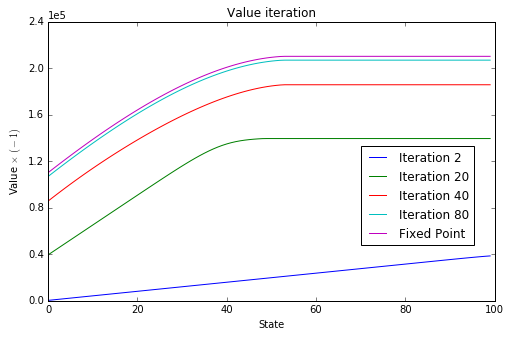

In [30]:
label = 'Value iteration'
iters = [2, 20, 40, 80]
v = np.zeros(ddp.num_states)

fig, ax = plt.subplots(figsize=(8,5))
for i in range(iters[-1]):
    v = ddp.bellman_operator(v)
    if i+1 in iters:
        ax.plot(-v, label='Iteration {0}'.format(i+1))
ax.plot(-results['Policy iteration'].v, label='Fixed Point')

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylim(0, 2.4e5)
ax.set_yticks([0.4e5 * i for i in range(7)])
ax.set_title(label)
ax.set_xlabel('State')
ax.set_ylabel(r'Value $\times\ (-1)$')
plt.legend(loc=(0.7, 0.2))
plt.show()

### Value iteration with span-based termination

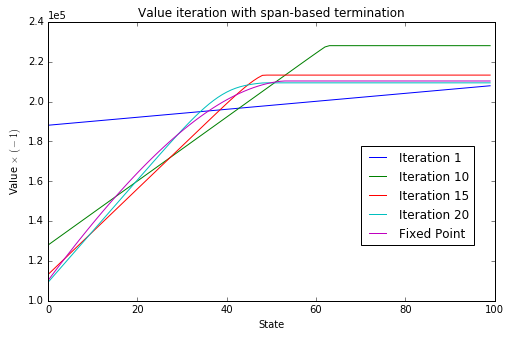

In [31]:
label = 'Value iteration with span-based termination'
iters = [1, 10, 15, 20]
v = np.zeros(ddp.num_states)

fig, ax = plt.subplots(figsize=(8,5))
for i in range(iters[-1]):
    u = ddp.bellman_operator(v)
    if i+1 in iters:
        diff = u - v
        w = u + ((diff.max() + diff.min()) / 2) * ddp.beta / (1 - ddp.beta)
        ax.plot(-w, label='Iteration {0}'.format(i+1))
    v = u
ax.plot(-results['Policy iteration'].v, label='Fixed Point')

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylim(1.0e5, 2.4e5)
ax.set_yticks([1.0e5+0.2e5 * i for i in range(8)])
ax.set_title(label)
ax.set_xlabel('State')
ax.set_ylabel(r'Value $\times\ (-1)$')
plt.legend(loc=(0.7, 0.2))
plt.show()

### Policy iteration

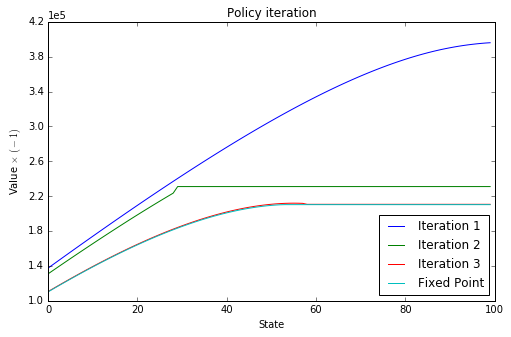

In [32]:
label = 'Policy iteration'
iters = [1, 2, 3]
v_init = np.zeros(ddp.num_states)

fig, ax = plt.subplots(figsize=(8,5))
sigma = ddp.compute_greedy(v_init)
for i in range(iters[-1]):
    # Policy evaluation
    v_sigma = ddp.evaluate_policy(sigma)
    if i+1 in iters:
        ax.plot(-v_sigma, label='Iteration {0}'.format(i+1))
    # Policy improvement
    new_sigma = ddp.compute_greedy(v_sigma)
    sigma = new_sigma
ax.plot(-results['Policy iteration'].v, label='Fixed Point')

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylim(1e5, 4.2e5)
ax.set_yticks([1e5 + 0.4e5 * i for i in range(9)])
ax.set_title(label)
ax.set_xlabel('State')
ax.set_ylabel(r'Value $\times\ (-1)$')
plt.legend(loc=4)
plt.show()

### Modified policy iteration

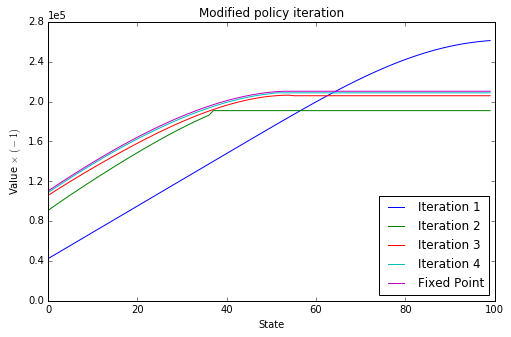

In [33]:
label = 'Modified policy iteration'
iters = [1, 2, 3, 4]
v = np.zeros(ddp.num_states)
k = 20 #- 1

fig, ax = plt.subplots(figsize=(8,5))
for i in range(iters[-1]):
    # Policy improvement
    sigma = ddp.compute_greedy(v)
    u = ddp.bellman_operator(v)
    if i == results[label].num_iter-1:
        diff = u - v
        break
    # Partial policy evaluation with k=20 iterations
    for j in range(k):
        u = ddp.T_sigma(sigma)(u)
    v = u
    if i+1 in iters:
        ax.plot(-v, label='Iteration {0}'.format(i+1))
ax.plot(-results['Policy iteration'].v, label='Fixed Point')

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylim(0, 2.8e5)
ax.set_yticks([0.4e5 * i for i in range(8)])
ax.set_title(label)
ax.set_xlabel('State')
ax.set_ylabel(r'Value $\times\ (-1)$')
plt.legend(loc=4)
plt.show()

## Increasing the discount factor

Let us consider the case with a discount factor closer to $1$, $\beta = 0.9999$.

In [34]:
ddp.beta = 0.9999

In [35]:
v_init = np.zeros(ddp.num_states)
epsilon = 1164
ddp.max_iter = 10**5 * 2

results_9999 = {}

for i in range(4):
    k = 20 if labels[i] == 'Modified policy iteration' else 0
    results_9999[labels[i]] = \
        ddp.solve(method=methods[i], v_init=v_init, epsilon=epsilon, k=k)

In [36]:
df_9999 = pd.DataFrame(index=labels, columns=columns)

The numbers of iterations:

In [37]:
for label in labels:
    print(results_9999[label].num_iter, '\t' + '(' + label + ')')
    df_9999[columns[0]].loc[label] = results_9999[label].num_iter

118900 	(Value iteration)
288 	(Value iteration with span-based termination)
7 	(Policy iteration)
18 	(Modified policy iteration)


Policy iteration gives the optimal policy:

In [38]:
print(results_9999['Policy iteration'].sigma)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Takes action 1 ("replace") if and only if $s \geq \bar{\gamma}$, where $\bar{\gamma}$ is equal to:

In [39]:
(1-results_9999['Policy iteration'].sigma).sum()

43

Check that the other methods gave the correct answer:

In [40]:
for result in results_9999.values():
    if result != results_9999['Policy iteration']:
        print(np.array_equal(result.sigma, results_9999['Policy iteration'].sigma))

True
True
True


$\lVert v - v_{\mathrm{pi}}\rVert$:

In [41]:
for label in labels:
    diff_pi = \
        np.abs(results_9999[label].v - results_9999['Policy iteration'].v).max()
    print(diff_pi, '\t' + '(' + label + ')')
    df_9999[columns[2]].loc[label] = diff_pi

581.998786509 	(Value iteration)
4.37767255306 	(Value iteration with span-based termination)
0.0 	(Policy iteration)
4.45491330326 	(Modified policy iteration)


$\lVert v - T(v)\rVert$:

In [42]:
for label in labels:
    v = results_9999[label].v
    diff_max = \
        np.abs(v - ddp.bellman_operator(v)).max()
    print(diff_max, '\t' + '(' + label + ')')
    df_9999[columns[4]].loc[label] = diff_max

0.0581999123096 	(Value iteration)
0.0558041036129 	(Value iteration with span-based termination)
5.96046447754e-08 	(Policy iteration)
0.052891805768 	(Modified policy iteration)


$\overline{b} - \underline{b}$:

In [43]:
for i in range(4):
    if labels[i] != 'Policy iteration':
        k = 20 if labels[i] == 'Modified policy iteration' else 0
        res = ddp.solve(method=methods[i], v_init=v_init, k=k,
                        max_iter=results_9999[labels[i]].num_iter-1)
        diff = ddp.bellman_operator(res.v) - res.v
        diff_span = (diff.max() - diff.min()) * ddp.beta / (1 - ddp.beta)
        print(diff_span, '\t' + '(' + labels[i] + ')')
        df_9999[columns[3]].loc[labels[i]] = diff_span

0.000446990132332 	(Value iteration)
1160.37531587 	(Value iteration with span-based termination)
1099.68602686 	(Modified policy iteration)


For policy iteration:

In [44]:
label = 'Policy iteration'
v = results_9999[label].v
diff = ddp.bellman_operator(v) - v
diff_span = (diff.max() - diff.min()) * ddp.beta / (1 - ddp.beta)
print(diff_span, '\t' + '(' + label + ')')
df_9999[columns[3]].loc[label] = diff_span

0.000893980264664 	(Policy iteration)


In [45]:
for i in range(4):
    k = 20 if labels[i] == 'Modified policy iteration' else 0
    print(labels[i])
    t = %timeit -o ddp.solve(method=methods[i], v_init=v_init, epsilon=epsilon, k=k)
    df_9999[columns[1]].loc[labels[i]] = t.best

Value iteration
1 loops, best of 3: 4.27 s per loop
Value iteration with span-based termination
10 loops, best of 3: 19.3 ms per loop
Policy iteration
100 loops, best of 3: 1.99 ms per loop
Modified policy iteration
100 loops, best of 3: 4.32 ms per loop


In [46]:
df_9999

,Iterations,Time (second),$\lVert v - v_{\mathrm{pi}} \rVert$,$\overline{b} - \underline{b}$,$\lVert v - T(v)\rVert$
Value iteration,118900,4.2675,581.999,0.00044699,0.0581999
Value iteration with span-based termination,288,0.0193439,4.37767,1160.38,0.0558041
Policy iteration,7,0.00199425,0,0.00089398,5.96046e-08
Modified policy iteration,18,0.00431983,4.45491,1099.69,0.0528918


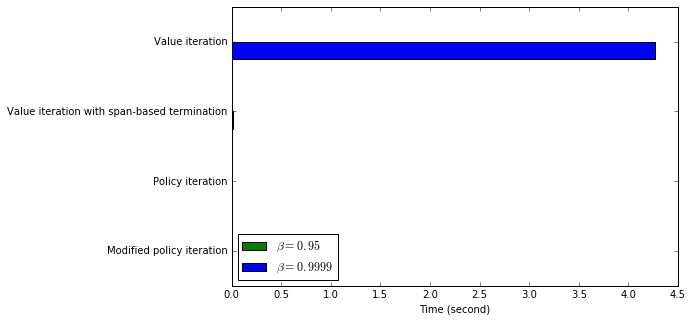

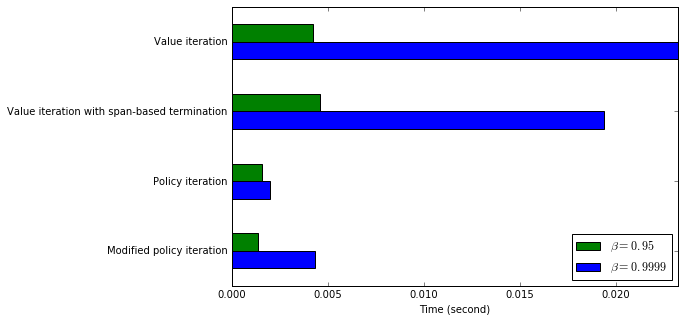

In [47]:
df_time = pd.DataFrame(index=labels)
df_time[r'$\beta = 0.95$'] = df[columns[1]]
df_time[r'$\beta = 0.9999$'] = df_9999[columns[1]]
second_max = df_time[r'$\beta = 0.9999$'][1:].max()

plt.rcParams['axes.color_cycle'] = ['g', 'b']
for xlim in [None, (0, second_max*1.2)]:
    ax = df_time.ix[reversed(labels)][df_time.columns[::-1]].plot(
        kind='barh', legend='reverse', xlim=xlim, figsize=(8,5)
    )
    ax.set_xlabel('Time (second)')

In [48]:
import platform
print(platform.platform())

Darwin-13.4.0-x86_64-i386-64bit


In [49]:
import sys
print(sys.version)

3.5.0 (default, Sep 23 2015, 04:41:33) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [50]:
print(np.__version__)

1.10.2
